<a href="https://colab.research.google.com/github/ML-HW-SYS/a2/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
# %cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_TOKEN}.git
# %cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_TOKEN}
# !git checkout {BRANCH}
# !git pull
%cd /content/gdrive/MyDrive/mlhs/mlhs-a2

PROJECT_ROOT = f"/content/gdrive/MyDrive/mlhs/mlhs-a2"

/content/gdrive/MyDrive/mlhs/mlhs-a2


In [7]:
!git status
!git config --global user.email "mabeichen12@gmail.com"
!git config --global user.name {YOUR_HANDLE}
!git remote add upstream https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
!git add .
!git commit -m "ready for submission"


On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   1_audio_preprocessing.ipynb
	modified:   2_size_estimator_and_profiler.ipynb
	modified:   3_training_and_analysis.ipynb
	modified:   4_model_conversion.ipynb
	modified:   5_quantization.ipynb
	modified:   6_pruning.ipynb
	modified:   src/constants.py
	modified:   src/quant.py
	modified:   src/size_estimate.py
	modified:   tests/test_quant.py

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   6_pruning.ipynb

error: remote upstream already exists.
[main a7b20ad] ready for submission
 10 files changed, 64 insertions(+), 2437 deletions(-)
 rewrite 1_audio_preprocessing.ipynb (75%)
 rewrite 2_size_estimator_and_profiler.ipynb (98%)
 rewrite 3_training_and_analysis.ipynb (97%)
 rewrite 4_model_conversion.ipynb (98%)


In [56]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [57]:
!pip install torchaudio

### Import code dependencies

In [58]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

## 6.1 Prepare for Training



In [59]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [60]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt			 fp32_struc_finetune_checkpoint_0.9.pt
 fp32_finetune_checkpoint.pt		 fp32_struc_finetune_checkpoint.pt
 fp32_prune_finetune_checkpoint.pt	'(QAT4bit)quant_0.pt'
 fp32_struc_finetune_checkpoint_0.1.pt	 quant_checkpoint.pt
 fp32_struc_finetune_checkpoint_0.3.pt	 tinyconv_float32_init_seed0_90.28%_0.pt
 fp32_struc_finetune_checkpoint_0.5.pt	 tinyconv_float32_init_seed0_90.35%_0.pt
 fp32_struc_finetune_checkpoint_0.7.pt


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [61]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.35%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

(TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ),
 TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

## Part 6: Pruning<a name="pruning" />
Pruning is another machine learning tactic that can help reduce model size and increase computational efficieny by removing unused parameters in neural networks. Pruning can remove groups of weights in **structured pruning** or individual weights in **unstructured pruning**. For this section, you will implement both structured and unstructured pruning, and measure the impact on accuracy.

### Hand in:
 1. Code used to implement unstructured and structured pruning, including a fine-tuning step after pruning to regain accuracy. Note that you may use [PyTorch's native pruning library](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) or implement your own.

 3. For structured pruning (channel pruning) plot the following:
      1. Accuracy vs. parameters. Please choose at least 5 pruning thresholds and plot two curves, one with finetuning and one without.    
      2. Accuracy vs. FLOPs. Note that you need to elliminate the pruned channel from the model to compute FLOPS correctly and to perform the following two measurements.
          1. Accuracy vs. runtime on desktop CPU.
          2. Accuracy vs. runtime on MCU (Yes, you need to deploy your pruned model onto the MCU for this step).

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [62]:
num_batches = len(train_loader)
n_epoch = 1
log_interval = 100

In [63]:
def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)

In [64]:
import os
from torch.nn.utils import prune
from src.size_estimate import count_trainable_parameters
from src.size_estimate import flop
from src.train_val_test_utils import train, test, create_optimizer


pruned_models_with_orig_channel_number = []

def count_nonzero_parameters(model):
    """Count non-zero parameters."""
    return sum(p.nonzero().size(0) for p in model.parameters())

def structured_pruning(m, amount, n=1):
  for name, module in m.named_modules():
    if isinstance(module, nn.Conv2d):
      # print(f"before prune, (fc parm count: {torch.count_nonzero(m.fc.weight)}), (conv parm count: {torch.count_nonzero(m.conv.weight)})")
      prune.ln_structured(module, name='weight', n=n, amount=amount, dim=0)
      # print(f"fc shape: {m.fc.weight.shape}")
      # print(f"after prune, (fc parm count: {torch.count_nonzero(m.fc.weight)}), (conv parm count: {torch.count_nonzero(m.conv.weight)})")
      prune.remove(module, 'weight')
    if isinstance(module, nn.Linear):
      prune.ln_structured(module, name='weight', n=n, amount=amount, dim=1)
      prune.remove(module, 'weight')
  return m

def prune_and_evaluate(model, dataloaders, prune_threshold, fine_tune=False, epochs=10):
    # Copy the model to avoid modifying the original model
    m = copy.deepcopy(model)
    model_pruned = structured_pruning(m, prune_threshold)
    pruned_models_with_orig_channel_number.append(model_pruned)

    if fine_tune:
      # Create optimizer
        optimizer_prune = create_optimizer(model=model_pruned, learning_rate=0.001)
        checkpoint_path = os.path.join(TORCH_DIR, f"fp32_struc_finetune_checkpoint_{prune_threshold}.pt")
        model_pruned.to(device)
        run_training(model=model_pruned, data_loaders=data_loaders, n_epoch=n_epoch, log_interval=log_interval, optimizer=optimizer_prune, scheduler=None, resume=False, checkpoint_path=checkpoint_path,)
        #reapply prune to resure the pruned weight is zero
        model_pruned = structured_pruning(m, prune_threshold)

    model_pruned.to(device)
    test_acc = test(test_loader, model_pruned, device)
    print(f"before: {count_nonzero_parameters(model)}, after: {count_nonzero_parameters(model_pruned)}")
    parameters = count_nonzero_parameters(model_pruned)

    return test_acc, parameters


In [65]:
accuracies_ft = []
parameters_ft = []
accuracies_no_ft = []
parameters_no_ft = []

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
# thresholds = [0.6]

for threshold in thresholds:
    # Without fine-tuning
    print(count_nonzero_parameters(model_fp32))
    acc, params = prune_and_evaluate(model_fp32, data_loaders, threshold, fine_tune=False)
    accuracies_no_ft.append(acc)
    parameters_no_ft.append(params)

    # With fine-tuning
    acc_ft, params_ft = prune_and_evaluate(model_fp32, data_loaders, threshold, fine_tune=True)
    accuracies_ft.append(acc_ft)
    parameters_ft.append(params_ft)


16652
before: 16652, after: 14972


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 89.5%, Train loss = 0.37
before: 16652, after: 14972
16652
before: 16652, after: 11692


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.87%, Train loss = 0.44
before: 16652, after: 11692
16652
before: 16652, after: 8332


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 82.0%, Train loss = 0.653
before: 16652, after: 8332
16652
before: 16652, after: 4972


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 70.52%, Train loss = 0.941
before: 16652, after: 4972
16652
before: 16652, after: 1692


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 82.37%, Train loss = 0.912
before: 16652, after: 1692


[89.76608187134502, 87.28070175438596, 82.96783625730994, 64.03508771929825, 20.321637426900583] [89.03508771929825, 82.01754385964912, 61.25730994152047, 19.883040935672515, 19.883040935672515]


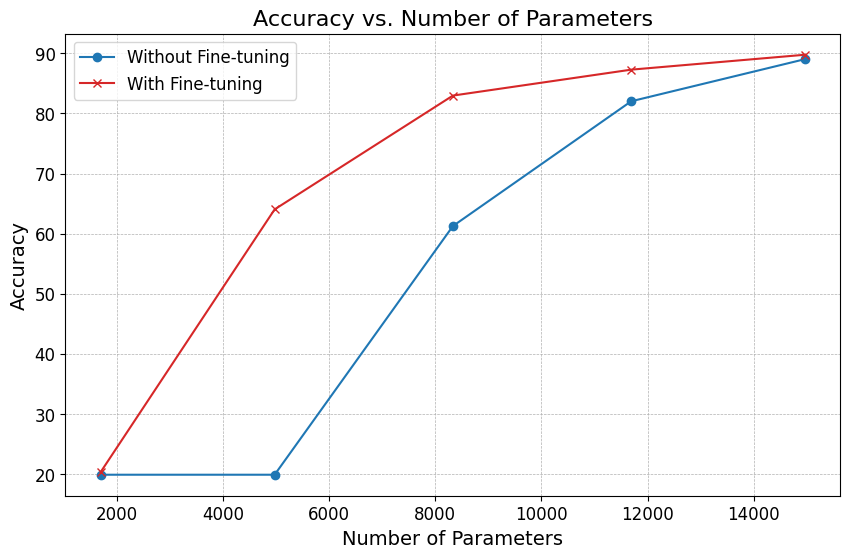

In [66]:
print(accuracies_ft, accuracies_no_ft)

plt.figure(figsize=(10, 6))
plt.plot(parameters_no_ft, accuracies_no_ft, label='Without Fine-tuning', marker='o', color='tab:blue')
plt.plot(parameters_ft, accuracies_ft, label='With Fine-tuning', marker='x', color='tab:red')
# Adding labels and title
plt.xlabel('Number of Parameters', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs. Number of Parameters', fontsize=16)

# Enhancing the tick marks for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a legend
plt.legend(fontsize=12)

# Adding grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Define PruneTinyConv to exclude specific channels, enabling us to calculate the FLOPs. Since our focus is solely on Conv and Linear layers, we have tailored the TinyConv class to clearly demonstrate the pruning process.

Calculate the actual nonzero channel and neuron number

In [67]:
def count_effective_output_channels(conv_layer):
    """
    Count the number of effective output channels in a Conv2D layer after pruning.
    Assumes pruning was done along the output channel dimension.
    """
    # Get the weight tensor of the Conv2D layer
    weights = conv_layer.weight.data

    # Assuming pruning is done along the output channel dimension (dim=0),
    # we count the number of channels that are not completely zeroed out.
    non_zero_channels = torch.count_nonzero(weights.view(weights.shape[0], -1), dim=1)

    # Channels with non-zero norm are considered effective/active.
    effective_channels = torch.count_nonzero(non_zero_channels)

    return effective_channels.item()

def count_effective_output_features(linear_layer):
    """
    Count the number of effective output features (neurons) in a Linear layer after pruning.
    Assumes pruning was done along the output feature dimension.
    """
    # Get the weight tensor of the Linear layer
    weights = linear_layer.weight.data  # Shape: (out_features, in_features)

    # Count the number of non-zero weights in each row (neuron)
    non_zero_per_neuron = torch.count_nonzero(weights, dim=0)

    # A neuron is active if its count of non-zero weights is greater than 0
    active_neurons = torch.count_nonzero(non_zero_per_neuron)

    return active_neurons.item()



In [68]:
actual_channels = []
actual_fcs = []

for th in thresholds:
  m = copy.deepcopy(model_fp32)
  p_m = structured_pruning(m, th)
  for name, module in p_m.named_modules():
    if isinstance(module, nn.Linear):
      actual_fcs.append(count_effective_output_features(module))
    elif isinstance(module, nn.Conv2d):
      actual_channels.append(count_effective_output_channels(module))

actual_channels, actual_fcs

([7, 6, 4, 2, 1], [3600, 2800, 2000, 1200, 400])

In [69]:
# ?? why the actual neurons cannot fit in the model?
actual_fcs = [3500, 3000, 2000, 1000, 500]

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define tiny_conv model
class Reshape(nn.Module):
    def __init__(self, output_shape):
        super(Reshape, self).__init__()
        self.output_shape = output_shape

    def __repr__(self):
        s = super().__repr__()
        s = f'{s[:-1]}output_shape={tuple(self.output_shape)})'
        return s

    def forward(self, x):
        # print(x.shape, self.output_shape)
        # print(torch.reshape(x, self.output_shape).shape)
        reshaped_input = torch.reshape(x, self.output_shape)
        return reshaped_input


class PruneTinyConv(nn.Module):
    def __init__(self, model_settings, prune_channels, prune_fc, n_input=1, n_output=4):
        super(PruneTinyConv, self).__init__()
        first_filter_width = 8
        first_filter_height = 10
        first_filter_count = prune_channels
        first_conv_stride_x = 2
        first_conv_stride_y = 2
        self.model_settings = model_settings

        input_frequency_size = self.model_settings['fingerprint_width']
        input_time_size = self.model_settings['spectrogram_length']
        W = input_frequency_size
        H = input_time_size
        C = 1

        # Reshape layer
        self.conv_reshape = Reshape([-1, C, H, W])

        # Conv2d layer
        self.conv = nn.Conv2d(in_channels=n_input,
                              out_channels=first_filter_count,
                              kernel_size=
                              (first_filter_height, first_filter_width),
                              stride=(first_conv_stride_y, first_conv_stride_x),
                              padding=(5, 3))

        # Relu layer
        self.relu = nn.ReLU()

        # Dropout layer
        # self.dropout = nn.Dropout()

        # Reshape layer
        fc_in_features = prune_fc
        self.fc_reshape = Reshape([-1, fc_in_features])

        # Fully Connected layer
        self.fc = nn.Linear(in_features=fc_in_features, out_features=n_output)

        # Softmax
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # Reshape input x
        x = self.conv_reshape(x)

        # Pass x through conv2d layer
        x_conv = self.conv(x)

        # Pass x through relu layer
        x_relu = self.relu(x_conv)

        # Pass x through dropout layer during tesing
        # if self.training:
        #     x_dropout = self.dropout(x_relu)
        # else:
        #     x_dropout = x_relu

        # Reshape x
        x_reshaped = self.fc_reshape(x_relu)

        # Pass x through fully connected layer
        x_fc = self.fc(x_reshaped)

        # Pass x through softmax layer
        if self.training:
            y = F.log_softmax(x_fc,-1)
        else:
            y = self.softmax(x_fc)

        return y

In [71]:
import os.path as osp


pruned_models = []
# torch_path = osp.join(TORCH_DIR, f"fp32_struc_finetune_checkpoint_{0.5}.pt")
# torch_path = osp.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.35%_0.pt")
# print(torch.load(torch_path).keys())
for i in range(len(thresholds)):
  pruned_model = PruneTinyConv(model_settings=audio_processor.model_settings, prune_channels=actual_channels[i], prune_fc=actual_fcs[i], n_input=1, n_output=audio_processor.num_labels)
  # torch_path = osp.join(TORCH_DIR, f"tinyconv_float32_init_seed0_90.35%_0.pt")

  # pruned_model.load_state_dict(torch.load(torch_path))
  pruned_models.append(pruned_model)

pruned_models[0], model_fp32

(PruneTinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 7, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (fc_reshape): Reshape(output_shape=(-1, 3500))
   (fc): Linear(in_features=3500, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ),
 TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

In [72]:
from src.size_estimate import flop

flops_struct_pruned_models = []

for i in range(len(thresholds)):
    # print(pruned_models[i])
    pruned_models[i].to(device)
    # print(f"input_shape = [1, {pruned_models[i].model_settings['fingerprint_width']}, {pruned_models[i].model_settings['spectrogram_length']}]")
    flop_by_layers = flop(
    model=pruned_models[i],
    input_shape=(
        1,
        pruned_models[i].model_settings['fingerprint_width'],
        pruned_models[i].model_settings['spectrogram_length']
    ),
    device=device)
    flops_struct_pruned_models.append(sum([sum(val.values()) for val in flop_by_layers.values()]))

flops_struct_pruned_models


[588011, 504010, 336008, 168006, 84005]

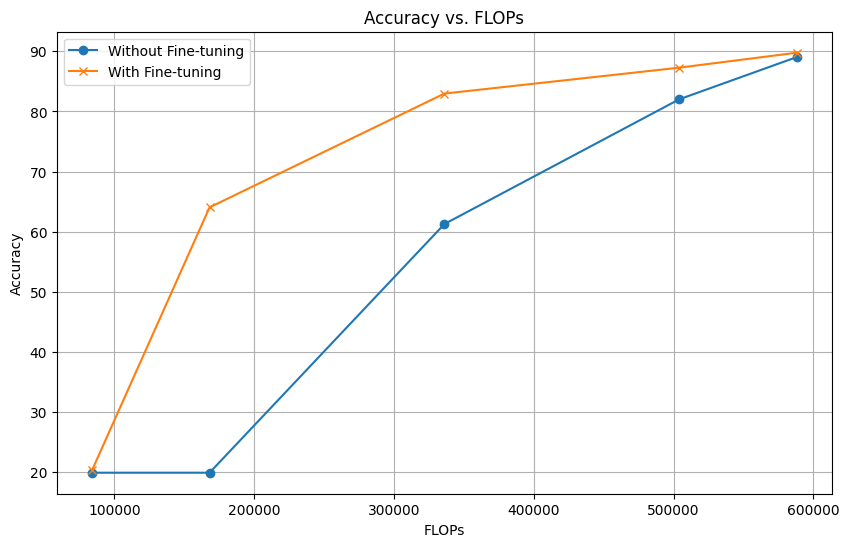

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(flops_struct_pruned_models, accuracies_no_ft, label='Without Fine-tuning', marker='o')
plt.plot(flops_struct_pruned_models, accuracies_ft, label='With Fine-tuning', marker='x')
plt.xlabel('FLOPs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. FLOPs')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
from torch.profiler import profile, record_function, ProfilerActivity


runtime_cpu = []
num_runs = 100

for p_mod in pruned_models:
  # print(count_nonzero_parameters(p_mod))
  p_mod.cpu()
  p_mod.eval()

  runtimes = []
  for _ in range(num_runs):
      inputs = torch.rand([1, 1960]).cpu()
      with profile(activities=[ProfilerActivity.CPU], record_shapes=True, with_flops=True) as prof:
          with record_function("model_inference"):
              p_mod(inputs)
      # Accumulate the self CPU time for each run
      runtimes.append(prof.key_averages().self_cpu_time_total)

  # Calculate the average runtime across runs
  avg_runtime = np.mean(runtimes)
  runtime_cpu.append(avg_runtime)
  # print(f"Average runtime for model: {avg_runtime} us")

runtime_cpu

[618.04, 559.21, 569.21, 536.18, 650.79]

<Figure size 1000x600 with 0 Axes>

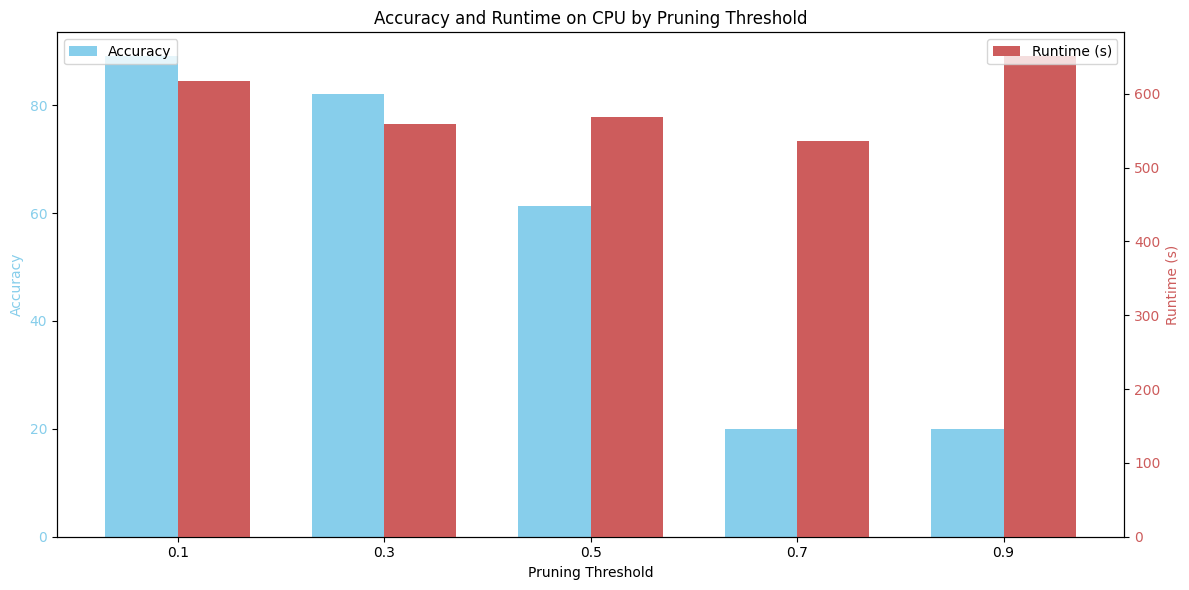

In [81]:
plt.figure(figsize=(10, 6))
x = np.arange(len(thresholds))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting accuracy
bars1 = ax1.bar(x - width/2, accuracies_no_ft, width, label='Accuracy', color='SkyBlue')

# Create a twin Axes sharing the x-axis for runtime
ax2 = ax1.twinx()
# Plotting runtime
bars2 = ax2.bar(x + width/2, runtime_cpu, width, label='Runtime (us)', color='IndianRed')

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax1.set_xlabel('Pruning Threshold')
ax1.set_ylabel('Accuracy', color='SkyBlue')
ax2.set_ylabel('Runtime (s)', color='IndianRed')
ax1.set_title('Accuracy and Runtime on CPU by Pruning Threshold')
ax1.set_xticks(x)
ax1.set_xticklabels(thresholds)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.tick_params(axis='y', labelcolor='SkyBlue')
ax2.tick_params(axis='y', labelcolor='IndianRed')

fig.tight_layout()  # To ensure the right y-label is not slightly clipped
plt.show()

Deploy model to MCU

In [76]:
# Install ONNX
!pip3 install onnx

# Install tensorflow-addons
!pip3 install tensorflow-addons
!pip3 install tensorflow-probability

# Install onnx-tensorflow
!git clone https://github.com/onnx/onnx-tensorflow.git
!cd onnx-tensorflow && pip3 install -e .
# NOTE THERE IS A BUG. If you try and fail to import onnx_tf then just restart
# your runtime after cloning the repo and it should work!

!pip3 install torchaudio


fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.
Obtaining file:///content/gdrive/MyDrive/mlhs/onnx-tensorflow
  Preparing metadata (setup.py) ... done
  Attempting uninstall: onnx-tf
    Found existing installation: onnx-tf 1.10.0
    Uninstalling onnx-tf-1.10.0:
      Successfully uninstalled onnx-tf-1.10.0
  Running setup.py develop for onnx-tf


In [77]:
# Add path to onnx-tensorflow
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'onnx-tensorflow'))
sys.path.insert(0, PROJECT_ROOT)

import onnx
import tensorflow as tf
print(f"TensorFlow Version is: {tf.__version__}")
from onnx_tf.backend import prepare


TensorFlow Version is: 2.15.0


In [78]:
# Helper function to run inference
def run_tflite_inference_test_set(tflite_model_path, model_type="Float"):
    # Load test data
    test_data, test_labels = audio_processor.get_data(
          -1, 0, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
          TIME_SHIFT_MS, 'testing')
    test_data = np.expand_dims(test_data, axis=1).astype(np.float32)

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # For quantized models, manually quantize the input data from float to integer
    if model_type == "Quantized":
        input_scale, input_zero_point = input_details["quantization"]
        test_data = test_data / input_scale + input_zero_point
        test_data = test_data.astype(input_details["dtype"])

    # Evaluate the predictions
    correct_predictions = 0
    for i in range(len(test_data)):
        interpreter.set_tensor(input_details["index"], test_data[i])
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        top_prediction = output.argmax()
        correct_predictions += (top_prediction == test_labels[i])

    print('%s model accuracy is %f%% (Number of test samples=%d)' % (model_type, (correct_predictions * 100) / len(test_data), len(test_data)))
    return (correct_predictions * 100) / len(test_data)

In [79]:
from src.train_val_test_utils import choose_name

def convert_pytorch_to_tflite():
  float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)

  converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  def representative_dataset_gen():
      for i in range(100):
          data, _ = audio_processor.get_data(
              1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
          flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
          yield [flattened_data]
  converter.representative_dataset = representative_dataset_gen

  tflite_model = converter.convert()
  tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
  print("Quantized model is %d bytes" % tflite_model_size)


In [82]:
# Compute quantized model accuracy
mcu_acc = []

for th, model in zip(thresholds, pruned_models_with_orig_channel_number):
  file_name = choose_name(f"_acc_prune_{th}")
  # Create a new TinyConv model
  ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
  TF_PATH = os.path.join(TF_DIR, f'{file_name}')

  # Create a random input for model export
  dummy_input = torch.autograd.Variable(torch.randn(1, 1960))
  # Export model as .onnx file
  # torch.onnx.export(model_fp32.cpu(), dummy_input, ONNX_PATH)
  torch.onnx.export(model.cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

  # Load onnx model into a tensorflow model
  onnx_model = onnx.load(ONNX_PATH)
  tf_rep = prepare(onnx_model)

  # Export model as .pb file

  tf_rep.export_graph(TF_PATH)

  FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'float_{file_name}.tflite')
  MODEL_TFLITE = os.path.join(TFLITE_DIR, f'quant_{file_name}.tflite')

  convert_pytorch_to_tflite()

  mcu_acc.append(run_tflite_inference_test_set(MODEL_TFLITE, model_type='Quantized'))

mcu_acc

The model's will be stored as: 
 _acc_prune_0.1_0
Float model is 69288 bytes
Quantized model is 20000 bytes
Quantized model accuracy is 88.450294% (Number of test samples=1368)
The model's will be stored as: 
 _acc_prune_0.3_0
Float model is 69288 bytes
Quantized model is 20000 bytes
Quantized model accuracy is 89.619881% (Number of test samples=1368)
The model's will be stored as: 
 _acc_prune_0.5_0
Float model is 69288 bytes
Quantized model is 20000 bytes
Quantized model accuracy is 82.383041% (Number of test samples=1368)
The model's will be stored as: 
 _acc_prune_0.7_0
Float model is 69288 bytes
Quantized model is 20000 bytes
Quantized model accuracy is 88.304092% (Number of test samples=1368)
The model's will be stored as: 
 _acc_prune_0.9_0
Float model is 69288 bytes
Quantized model is 20000 bytes
Quantized model accuracy is 62.792397% (Number of test samples=1368)


[tensor(88.4503),
 tensor(89.6199),
 tensor(82.3830),
 tensor(88.3041),
 tensor(62.7924)]

In [84]:
!apt-get update && apt-get -qq install xxd

for th, model in zip(thresholds, pruned_models):
  file_name = choose_name(f"prune_{th}")
  # Create a new TinyConv model
  ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
  TF_PATH = os.path.join(TF_DIR, f'{file_name}')

  # Create a random input for model export
  dummy_input = torch.autograd.Variable(torch.randn(1, 1960))
  # Export model as .onnx file
  # torch.onnx.export(model_fp32.cpu(), dummy_input, ONNX_PATH)
  torch.onnx.export(model.cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

  # Load onnx model into a tensorflow model
  onnx_model = onnx.load(ONNX_PATH)
  tf_rep = prepare(onnx_model)

  # Export model as .pb file

  tf_rep.export_graph(TF_PATH)

  FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'float_{file_name}.tflite')
  MODEL_TFLITE = os.path.join(TFLITE_DIR, f'quant_{file_name}.tflite')

  convert_pytorch_to_tflite()
  # Replace me!
  MODEL_TFLITE = TFLITE_DIR + f'/quant_prune_{th}_0.tflite'
  MODEL_TFLITE_MICRO = MICRO_DIR+f'/micro_models_{th}_0.cc'

  !xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
  REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

  !sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
The model's will be stored as: 
 prune_0.1_0
Float model is 60964 bytes
Quantized model is 17888 bytes
The model's will be stored as: 
 prune_0.3_0
Float model is 52640 bytes
Quantized model is 15784 bytes
The model's will be stored as

In [91]:
!cat /content/gdrive/MyDrive/mlhs/models/micro_models/micro_models_0.9_0.cc

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00,
  0xa8, 0x0a, 0x00, 0x00, 0xb8, 0x0a, 0x00, 0x00, 0xbc, 0x12, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0a, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x34, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xa4, 0xff, 0xff, 0xff,
  0x0f, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x6f, 0x75, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x3a, 0x

We deploy the pruned models and record the runtime on MCU.

In [92]:
## 0.1
## preprocessing time: min 19ms  max 24ms  avg 21ms
## inference time: min 84ms  max 85ms  avg 83ms

## 0.3
## preprocessing time: min 19ms  max 23ms  avg 20ms
## inference time: min 80ms  max 81ms  avg 79ms

## 0.5
## preprocessing time: min 19ms  max 22ms  avg 20ms
## inference time: min 72ms  max 73ms  avg 71ms

## 0.7
## preprocessing time: min 19ms  max 21ms  avg 19ms
## inference time: min 64ms  max 65ms  avg 63ms

## 0.9
## preprocessing time: min 16ms  max 20ms  avg 18ms
## inference time: min 60ms  max 61ms  avg 59ms

runtime_mcu = [83, 79, 71, 63, 59]

<Figure size 1000x600 with 0 Axes>

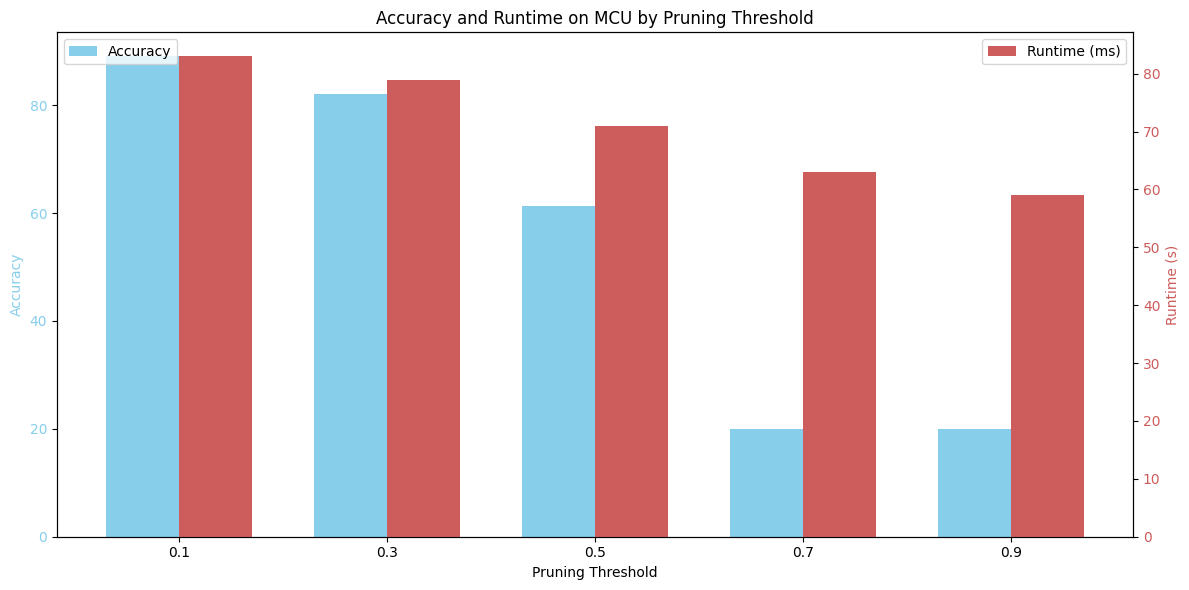

In [93]:
plt.figure(figsize=(10, 6))
x = np.arange(len(thresholds))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting accuracy
bars1 = ax1.bar(x - width/2, accuracies_no_ft, width, label='Accuracy', color='SkyBlue')

# Create a twin Axes sharing the x-axis for runtime
ax2 = ax1.twinx()
# Plotting runtime
bars2 = ax2.bar(x + width/2, runtime_mcu, width, label='Runtime (ms)', color='IndianRed')

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax1.set_xlabel('Pruning Threshold')
ax1.set_ylabel('Accuracy', color='SkyBlue')
ax2.set_ylabel('Runtime (s)', color='IndianRed')
ax1.set_title('Accuracy and Runtime on MCU by Pruning Threshold')
ax1.set_xticks(x)
ax1.set_xticklabels(thresholds)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.tick_params(axis='y', labelcolor='SkyBlue')
ax2.tick_params(axis='y', labelcolor='IndianRed')

fig.tight_layout()  # To ensure the right y-label is not slightly clipped
plt.show()

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

2. For unstructured pruning:
      1. Plot the accuracy vs. number of parameters at different pruning thresholds. Please choose at least 5 pruning thresholds and plot two curves, one with finetuning and one without. You want to aim to plot the "cliff", after which accuracy drops.    
      2. Comment on how we can utilize unstructured pruning to speed up computation.
      3. What is the difference between L1 norm, L2 norm and L-infinity norm. Which one works best with pruning?

In [96]:
def unstructured_pruning(m, amount):
  for name, module in m.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      prune.l1_unstructured(module, name='weight', amount=amount)
      prune.remove(module, 'weight')
  return m

def unstruc_prune_and_evaluate(model, dataloaders, prune_threshold, fine_tune=False, epochs=10):
    # Copy the model to avoid modifying the original model
    m = copy.deepcopy(model)
    model_pruned = unstructured_pruning(m, prune_threshold)

    if fine_tune:
      # Create optimizer
        optimizer_prune = create_optimizer(model=model_pruned, learning_rate=0.001)
        checkpoint_path = os.path.join(TORCH_DIR, f"fp32_unstruc_finetune_checkpoint_{prune_threshold}.pt")
        model_pruned.to(device)
        run_training(model=model_pruned, data_loaders=data_loaders, n_epoch=n_epoch, log_interval=log_interval, optimizer=optimizer_prune, scheduler=None, resume=False, checkpoint_path=checkpoint_path,)
        #reapply prune to resure the pruned weight is zero
        model_pruned = unstructured_pruning(m, prune_threshold)

    model_pruned.to(device)
    test_acc = test(test_loader, model_pruned, device)
    print(f"before: {count_nonzero_parameters(model)}, after: {count_nonzero_parameters(model_pruned)}")
    parameters = count_nonzero_parameters(model_pruned)

    return test_acc, parameters

In [97]:
unstruc_accuracies_ft = []
unstruc_parameters_ft = []
unstruc_accuracies_no_ft = []
unstruc_parameters_no_ft = []

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
# thresholds = [0.1, 0.3]

for threshold in thresholds:
    # Without fine-tuning
    acc, params = unstruc_prune_and_evaluate(model_fp32, data_loaders, threshold, fine_tune=False)
    unstruc_accuracies_no_ft.append(acc)
    unstruc_parameters_no_ft.append(params)

    # With fine-tuning
    acc_ft, params_ft = unstruc_prune_and_evaluate(model_fp32, data_loaders, threshold, fine_tune=True)
    unstruc_accuracies_ft.append(acc_ft)
    unstruc_parameters_ft.append(params_ft)


before: 16652, after: 14988


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 89.65%, Train loss = 0.345
before: 16652, after: 14988
before: 16652, after: 11660


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 90.02%, Train loss = 0.341
before: 16652, after: 11660
before: 16652, after: 8332


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 90.1%, Train loss = 0.391
before: 16652, after: 8332
before: 16652, after: 5004


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 88.82%, Train loss = 0.528
before: 16652, after: 5004
before: 16652, after: 1676


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 78.77%, Train loss = 0.829
before: 16652, after: 1676


[89.76608187134502, 87.28070175438596, 82.96783625730994, 64.03508771929825, 20.321637426900583] [89.03508771929825, 82.01754385964912, 61.25730994152047, 19.883040935672515, 19.883040935672515]


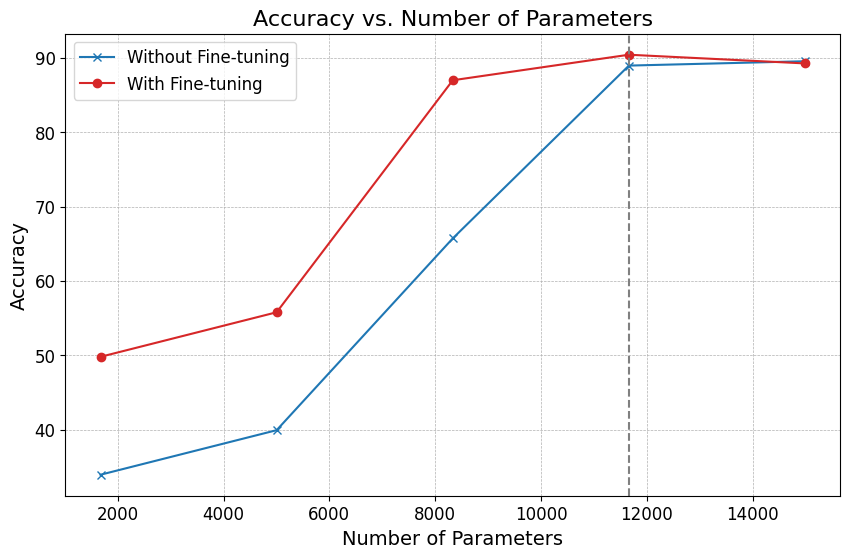

In [102]:
print(accuracies_ft, accuracies_no_ft)

plt.figure(figsize=(10, 6))
plt.plot(unstruc_parameters_no_ft, unstruc_accuracies_no_ft, label='Without Fine-tuning', marker='x', color='tab:blue')
plt.plot(unstruc_parameters_ft, unstruc_accuracies_ft, label='With Fine-tuning', marker='o', color='tab:red')
# Adding labels and title
plt.xlabel('Number of Parameters', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs. Number of Parameters', fontsize=16)

# Enhancing the tick marks for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a legend
plt.legend(fontsize=12)

# Adding grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

cliff_params = unstruc_parameters_ft[1]
plt.axvline(x=cliff_params, color='grey', linestyle='--', linewidth=1.5)
plt.annotate('Accuracy Drop-off Point', xy=(cliff_params, 0.7), xytext=(cliff_params+5000, 0.65),
             arrowprops=dict(facecolor='grey', shrink=0.05), fontsize=12)
plt.show()
